### 第10天：TensorFlow2项目实战—基于迭代的风格迁移

#### 风格迁移：将图像A的纹理、色彩、视觉模式等风格特征迁移到图像B的内容上，得到一个风格特征和A相像，内容和B一样的合成图像C。其中图像A称为风格图像，图像B称为内容图像；

参考论文: https://openaccess.thecvf.com/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

### 1、思路

建立如下一个优化的函数：

 $$L(C)=\beta Lc(C,B)+\alpha Ls(C,A) $$
 
其中$Lc(C,B)$表示图像C和图像B的内容差异度函数，$Ls(C,A)$表示图像C和图像A的风格差异度函数，$\beta，\alpha$分别表示图像C在风格和内容上像原图的偏重程度。通过获得上述函数的最小值就得到了合成图像C。

### 2、原理

现在的问题是如何定义风格、内容差异度函数？ 对于深层CNN而言，每一层都可以学到图片的某些特征，并且可以认为低层学到的是图像的边界、纹路、颜色等风格特征，而深层可以学到图像的内容特征。

### 2.1 内容差异度函数

可以通过计算两幅图像的深层的特征映射的欧氏距离来定义其内容差异度函数$Lc$。假设$Pa^{L}、Px^{L}$分别是图像$a$，图像$x$对应某个CNN的第$L$层网络的特征映射，$Pa^{L}_{ij}、Px^{L}_{ij}$分别是第$L$层网络的第$i$个滤波器产生的特征映射的第$j$个元素，其中$i \in [1, N^{L}], N^{L}$为第$L$层网络的滤波器的个数；$j \in [1, M^{L}]，M^{L}$为第$L$层网络的滤波器产生的特征映射的宽度与高度的乘积；因此图像$a$和图像$x$在第L层的内容差异度函数可以定义为：

$$Lc^{L}(a,x)=\frac{1}{2} \sum_{i=1}^{N^{L}} \sum_{j=1}^{M ^{L}} (Pa_{ij}^{l}-Px_{ij}^{l})^{2}$$

### 2.2 风格差异度函数

现在考虑是否可以用类似于内容差异度的函数定义风格差异度，也就是计算低层网络的特征映射的欧氏距离来表示风格差异度。答案是不可以的，因为低层网络学到的空间信息(例如位置、边界等)很显著，而这些信息并不算是图像的风格特征，因此需要在保留其他信息的前提下消除空间信息的影响。Gatys想到利用Gram矩阵来实现。图像a在第$L$层的Gram矩阵为：

$$Ga^{L}_{ij} = \sum_{k}^{M^{L}}Pa_{ik}^{l}Pa_{jk}^{l}$$

$$Ga^{L} = \begin{bmatrix}
Pa^{0} \cdot Pa^{0}&  Pa^{0} \cdot Pa^{1}&  \cdots & Pa^{0} \cdot Pa^{N^{L}}\\ 
Pa^{1} \cdot Pa^{0}&  Pa^{1} \cdot Pa^{1}&  \cdots & Pa^{1} \cdot Pa^{N^{L}}\\ 
\cdots &  \cdots&  \cdots& \cdots \\ 
Pa^{N^{L}} \cdot Pa^{0}&  Pa^{N^{L}} \cdot Pa^{1}&  \cdots & Pa^{N^{L}} \cdot Pa^{N^{L}}
\end{bmatrix},Ga^{L}\in R^{N^{L}\times N^{L}}$$



上面的Gram矩阵中的元素为第L层网络$N^{L}$个滤波器产生的特征映射各自变为向量后的两两之间的内积。因此图像$a$和图像$x$在第L层的风格差异度函数就可以按照如下定义：

$$Ls^{L}(a,x)=\frac{1}{4{N^{L}}^{2}{M^{L}}^{2}} \sum_{i=1}^{N ^{L}}\sum_{j=1}^{M ^{L}} (Ga_{ij}^{l}-Gx_{ij}^{l})^{2}$$

现在说一下为什么Gram矩阵可以。$Ga_{ij}^{l}$是内积，这个量和位置是没有关系的，不像内容差异度函数中的$Pa_{ij}^{l}$是某个位置上的量。此外，内积是一种相关性的体现，也可以视为风格的体现；

### 3 基于迭代的风格迁移—实现步骤

+ 3.1准备阶段
    + 选择风格图像和内容图像，对于内容图像，像素大的图片，程序运行时间较长，本例像素最大值限制为500，等比例缩放；
    + 初始合成图像：直接选择内容图像（本例）或者在内容图像上添加一定比例的噪声，或者用随机生成的白噪声图片；
    
+ 3.2 模型阶段

    + 下载一个已经训练好的模型，例如本例中的VGG19（注意不需要输出层之前的三个全连接层）；
    + 设置内容层的列表，并获得内容图像在对应层的输出，以此作为训练的内容目标；
    + 设置风格层的列表，并计算风格图像在对应层输出的Gram矩阵，以此作为训练的风格目标；
    + 将初始合成图像作为变量，开始迭代：
       1. 获得合成图像在设置好的内容层和风格层中的输出，分别计算内容损失和风格损失
       2. 内容损失:计算合成图像每一个内容层对应的输出和对应层的内容目标的差异，并计算均值；风格损失：计算合成图像每一个风格层对应的输出和对应层的风格目标的差异，并计算均值；
       3. 根据权重将上面两种损失加权求和得到总损失；
       4. 求得总损失关于合成图像的梯度；
       5. 利用梯度下降法更新合成图像；
    + 结束迭代；
       
         
+ 3.3 合成图像效果优化 

  根据上面方法得到的图像，它会产生大量的高频误差。 所谓高频误差就是合成图像中有很多的边缘痕迹，生成的图像比较生硬，不柔和。可以直接通过正则化图像的高频分量来减少这些高频误差。在风格转移中，这通常被称为总变分损失。
     

### 4 基于Tensorflow2实现

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
plt.rcParams['font.family'] = 'SimHei'  # 绘图显示中文 
plt.rcParams['axes.unicode_minus']=False  # 绘图显示负号
print('tensorlfow版本:',tf.__version__)

tensorlfow版本: 2.1.0


### 4.1 图像参数设置

In [9]:
# 风格图像名称
STYLE_FIG = 'style_Composition7.jpg'
# 内容图像名称
CONTENT_FIG = '4.jpeg'  
# 内容图像最大像素500
Max_P = 500  # 越大生成图像的速度越慢

### 4.2 模型准备

In [10]:
# 下载VGG19模型:首次运行，需要时间下载
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [11]:
class TSMODEL:
    
    def __init__(self,contentfigpath=CONTENT_FIG,stylefigpath=STYLE_FIG, m=model):
        # 模型
        self.m = m  # 预训练好的VGG19模型
        
        # 图像数据
        self.nsf = self.get_fig_data(stylefigpath)  # 风格图像
        self.cf = self.get_fig_data(contentfigpath, 'c')  # 内容图像
        
        # 根据网络的层结构，选择相应的内容层和风格层，以及各层对应的权重 
        self.content_layers = [['block5_conv2', 1], ['block5_conv3', 1]]
        self.style_layers = [['block1_conv1',0.5],['block2_conv1',0.5], ['block3_conv1',1], ['block4_conv1',2],['block5_conv1',2]]
    
    # 保证图像数据在0-1之间
    def clip_0_1(self,imagedata):
        return tf.clip_by_value(imagedata, clip_value_min=0.0, clip_value_max=1.0)
    
    # 获取图像的数据: RGB 格式。0-1之间。
    def get_fig_data(self,figname, figc='s', mp=Max_P):
        data = Image.open(figname)
        # 如果是内容图片，并且宽或者高的像素大于最大像素，则进行调整
        if figc =='c':
            shape = np.array(data).shape
            max_hw = shape[0] if shape[0] > shape[1] else shape[1]
            if max_hw > mp:
                scale = mp / max_hw
                new_shape = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32).numpy()[:2]
                data = data.resize(list(new_shape)[::-1],Image.ANTIALIAS)
        # 转换类型
        data= tf.cast(np.array(data), tf.float32)
        # 将图片数据变为0-1
        if np.mean(data)> 1:
            data = data / 255
        # 输出的数据维度是（1，*，*，3）
        data_last = tf.expand_dims(data, axis=0) 
        return data_last
    
    # 需要将数据变为VGG19模型的格式：效果等于tf.keras.applications.vgg19.preprocess_input
    #（1）输入数组的值在0-1之间（2）RGB变为BGR，（3）减去各通道对应的均值. （4）输入\输出维度保证是4维的（1，*，*，3）
    def handle_vgg19_data(self, input_data):
        red, green, blue = tf.split(input_data*255,axis=3, num_or_size_splits=3)
        input_data = tf.concat(axis=3, values=[blue-103.939 ,green-116.779 ,red-123.68])
        return input_data
            
    
    # 卷积函数，卷积后需要做relu的计算
    def conv_relu_func(self, input_data, net_para_data):
        filters, bias = net_para_data
        # 卷积
        conv_result = tf.nn.conv2d(input_data, filters, strides=[1, 1, 1, 1], padding='SAME') + bias
        # Relu函数
        relu_result = tf.nn.relu(conv_result)
        return relu_result

    # 池化函数
    def pool_func(self, input_data):
        # 最大池化
        return tf.nn.max_pool(input_data, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # 根据层的索引号读取模型的参数
    def get_model_para(self, sign):
        para_data = self.m.layers[sign].get_weights()
        filters = tf.constant(para_data[0])
        bias = tf.constant(para_data[1])
        return filters,bias
    
    # 计算风格层的Gram矩阵
    def gram_matrix(self,input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
        return result/(num_locations)

    # 根据VGG19模型的参数以及相应的图片选择相应的层的输出
    def get_vggnet19_output(self,input_data):
        # 对输入数据进行VGG19模型的处理
        input_data = self.handle_vgg19_data(input_data)
        net = {}
        for layer_sign, layer_name in enumerate(self.m.layers):
            lname = layer_name.name
            if 'conv' in lname:
                net[lname] = self.conv_relu_func(net[forward_name], self.get_model_para(layer_sign))
            elif 'pool' in lname:
                net[lname] = self.pool_func(net[forward_name])
            # 输入层
            else:
                net[lname] = input_data
            forward_name = lname
        
        # 层的输出
        layer_output = {}
        # 内容层
        layer_output['content'] = {}
        for cl in self.content_layers:
            # 获得输出和权重
            layer_name_str, layer_weight = cl
            # 存储
            layer_output['content'][layer_name_str] = [net[layer_name_str], layer_weight]
        
        # 风格层
        layer_output['style'] = {}
        for sl in self.style_layers:
            # 获得输出和权重
            layer_name_gram, layer_weight = sl
            # 计算Gram
            layer_output['style'][layer_name_gram] = [self.gram_matrix(net[layer_name_gram]), layer_weight]
        return layer_output

In [12]:
# 内容图像和风格图像
mj = TSMODEL()

### 4.3 计算损失

In [13]:
# 内容图像-目标
content_target_output = mj.get_vggnet19_output(mj.cf)['content']
# 风格图像-目标
style_target_output = mj.get_vggnet19_output(mj.nsf)['style']

# 内容层总的权重
weight_content = 1e4
# 风格层总的权重
weight_style = 1e-2

# 根据合成图像的输出定义内容和风格的损失函数
def style_content_loss(compose_outputs, cto=content_target_output, sto=style_target_output, 
                       content_weight=weight_content,style_weight=weight_style):
    # 合成图像的输出
    style_outputs = compose_outputs['style']
    content_outputs = compose_outputs['content']

    # 内容损失
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name][0]-cto[name][0])**2 * cto[name][1]) for name in cto.keys()])
    content_loss *= content_weight / len(cto)
    
    # 风格损失
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name][0] -sto[name][0])**2 * sto[name][1]) for name in sto.keys()])
    style_loss *= style_weight / len(sto)
    # 总共的损失
    loss = style_loss + content_loss
    return loss


### 4.5 模型迭代

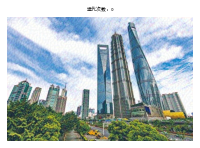

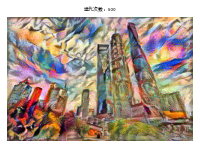

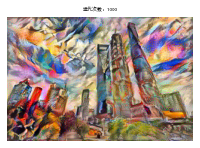

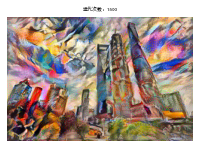

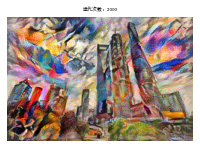

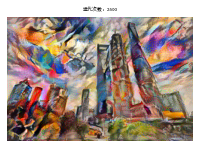

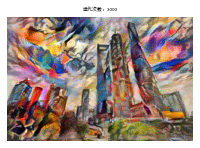

In [7]:
# 梯度下降获得合成图像
def train_step(cfig_data):
    with tf.GradientTape() as tape:
        # 合成图像的输出
        outputs = mj.get_vggnet19_output(cfig_data)
        # 计算损失
        loss = style_content_loss(outputs)
    # 应用梯度下降
    grad = tape.gradient(loss, cfig_data)
    opt.apply_gradients([(grad, cfig_data)])
    cfig_data.assign(mj.clip_0_1(cfig_data))
    return cfig_data, loss

# 合成的图像看作变量:直接用原始的内容图像
com_image=tf.Variable(mj.cf)

LOSS = []

# 优化器
opt = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)

# 开始迭代
for i in range(3001):
    com_image, loss_number = train_step(com_image)
    LOSS.append(loss_number)
    if i % 500 == 0:
        # 图片数据
        h, w, c = com_image[0].numpy().shape
        fig = plt.gcf()
        fig.set_size_inches(h/100,w/100)
        plt.imshow(com_image[0].numpy())
        plt.axis('off')
        plt.title('迭代次数：%s' % i, fontsize=5)
        plt.savefig('normal_%s.png' % i, dpi=220,bbox_inches='tight',pad_inches=0.03)
        plt.show()

### 4.6 模型优化

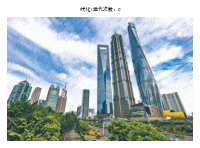

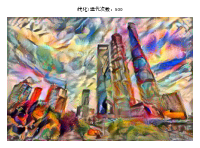

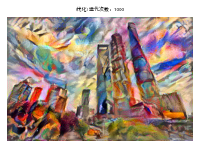

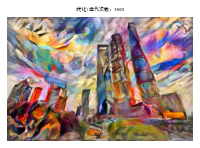

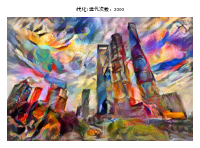

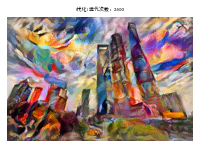

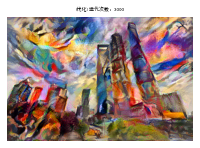

In [14]:
# 模型优化
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

# 总变分损失
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

# 总变分损失权重
total_variation_weight = 20

# 优化器
opt = tf.optimizers.Adam(learning_rate=0.03, beta_1=0.99, epsilon=1e-1)
# 梯度下降获得合成图像
def train_step(cfig_data, tvw=total_variation_weight):
    with tf.GradientTape() as tape:
        # 合成图像的输出
        outputs = mj.get_vggnet19_output(cfig_data)
        # 计算损失
        scloss = style_content_loss(outputs)
        # 总变分损失
        tvloss = tvw*total_variation_loss(cfig_data)
        # 总损失
        loss = scloss + tvloss
    # 应用梯度下降
    grad = tape.gradient(loss, cfig_data)
    opt.apply_gradients([(grad, cfig_data)])
    cfig_data.assign(mj.clip_0_1(cfig_data))
    return cfig_data, loss

# 合成的图像看作变量
bestimage=tf.Variable(mj.cf)

BLOSS = []

# 开始迭代
for i in range(3001):
    bestimage, loss = train_step(bestimage)
    BLOSS.append(loss)
    if i % 500 == 0:
        h, w, c = bestimage[0].numpy().shape
        fig = plt.gcf()
        fig.set_size_inches(h/100,w/100)
        plt.imshow(bestimage[0].numpy())
        plt.axis('off')
        plt.title('(优化)迭代次数：%s' % i, fontsize=5)
        plt.savefig('bests_%s.png' % i, dpi=220,bbox_inches='tight',pad_inches=0.03)
        plt.show()